In [2]:
# A single-file scripts for synthetic data set generating 
# This file is used to re-generate the ellipse dataset, and the re-generated imaeg data will be slightly different because of randomness
# Please use our uploaded ellipse image data in the folder 'ellipse_dataset' to better replicate our results presented in supplementary

import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image, ImageOps
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import sys
import torch.optim as optim
import math
sys.path.append(".")



In [47]:
# Define means for the four variables (Area, Rotation, Position, Brightness)
mean = (400, 90, 31, 128+20)  # Mean area, mean rotation, mean position, mean brightness

# Standard deviations
std_var1 = np.sqrt(9500)  # Standard deviation for Var1 (Area)
std_var2 = np.sqrt(400)   # Standard deviation for Var2 (Rotation) #was 300
std_var3 = np.sqrt(20)   # Standard deviation for Var3 (Position)
std_var4 = 35            # Standard deviation for Var4 (Brightness)

correlation_14 = -0.4   # Correlation between Area and Brightness
correlation_24 = 0.4   # Correlation between Rotation and Brightness
correlation_34 = 0.4   # Correlation between Position and Brightness

# Calculate covariances based on desired correlations
cov_var1_var4 = correlation_14 * std_var1 * std_var4
cov_var2_var4 = correlation_24 * std_var2 * std_var4
cov_var3_var4 = correlation_34 * std_var3 * std_var4

# Construct the covariance matrix with specified correlations
cov = np.array([
    [std_var1**2, 0, 0, cov_var1_var4],  # Var1's covariances
    [0, std_var2**2, 0, cov_var2_var4],  # Var2's covariances
    [0, 0, std_var3**2, cov_var3_var4],  # Var3's covariances
    [cov_var1_var4, cov_var2_var4, cov_var3_var4, std_var4**2]  # Var4's covariances
])

# Generate points
pts = np.random.multivariate_normal(mean, cov, size=8000)

# Define bounds for each variable
area_min, area_max = 0, 3000
rotation_min, rotation_max = 10, 170
position_min, position_max = 31-15, 31+15
brightness_min, brightness_max = 40, 255

# Clip values to be within specified ranges
pts[:, 0] = np.clip(pts[:, 0], area_min, area_max)    # Area
pts[:, 1] = np.clip(pts[:, 1], rotation_min, rotation_max)  # Rotation
pts[:, 2] = np.clip(pts[:, 2], position_min, position_max)  # Position
pts[:, 3] = np.clip(pts[:, 3], brightness_min, brightness_max)  # Brightness

# Create directory if it doesn't exist
output_dir = 'ellipse_dataset_ver2/'
os.makedirs(output_dir, exist_ok=True)

In [48]:
pts.mean(axis=0)

array([399.97246033,  89.96189117,  30.97212361, 147.92443735])

In [49]:
np.cov(pts.T)

array([[ 9.60004496e+03,  6.39294847e+01,  1.74321405e+00,
        -1.38233059e+03],
       [ 6.39294847e+01,  3.98791036e+02,  8.15215629e-01,
         2.73024692e+02],
       [ 1.74321405e+00,  8.15215629e-01,  2.03571698e+01,
         6.17758362e+01],
       [-1.38233059e+03,  2.73024692e+02,  6.17758362e+01,
         1.22923376e+03]])

Correlation between Area and Brightness: -0.40240006994357025
Correlation between Angle and Brightness: 0.389952755484819
Correlation between Position and Brightness: 0.39051947206059184
sqrt(1 - corr^2(Area, Brightness) - corr^2(Angle, Brightness) - corr^2(Position, Brightness)): 0.7304146590401396


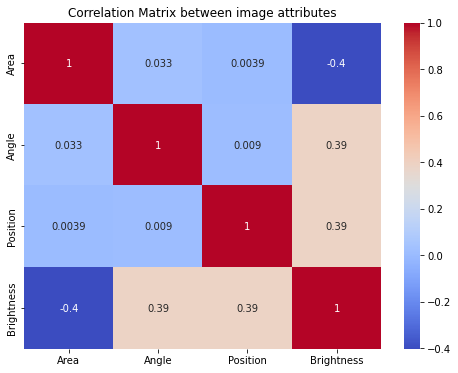

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `pts` is a generated matrix with columns corresponding to Var1, Var2, Var3, and Var4
# with the following meanings:
# Var1 -> Area, Var2 -> Angle, Var3 -> Position, Var4 -> Brightness

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(pts.T)

# Define variable names for labeling
variable_names = ['Area', 'Angle', 'Position', 'Brightness']

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=variable_names, yticklabels=variable_names)
plt.title("Correlation Matrix between image attributes")
#plt.show()

# Optional: Display each pair's correlation if needed
print("Correlation between Area and Brightness:", correlation_matrix[0, 3])
print("Correlation between Angle and Brightness:", correlation_matrix[1, 3])
print("Correlation between Position and Brightness:", correlation_matrix[2, 3])

# Calculate and print the result as you did before
result = np.sqrt(1 - correlation_matrix[0, 3]**2 - correlation_matrix[1, 3]**2 - correlation_matrix[2, 3]**2)
print("sqrt(1 - corr^2(Area, Brightness) - corr^2(Angle, Brightness) - corr^2(Position, Brightness)):", result)
plt.savefig('fig_mr/correlation_matrix.svg', format='svg', dpi=1200,bbox_inches="tight")

In [51]:
area = pts[:, 0]
rotation = pts[:, 1]
position = pts[:, 2]
brightness = pts[:, 3]  # Convert brightness scale

In [52]:
print(np.std(area))

97.9736952273964


In [55]:
df_all = pd.DataFrame({'Area':area, 'Brightness':brightness/255, 'Angle':rotation, 'Position':position}) #convert gray scale to brightness 0-1
df_all.to_csv('fig_mr/df_ver1.csv',index=None)
#df_all
#df_rad_thickness = pd.DataFrame({'Radius':r_ball_list, 'thickness':thickness_list}) #convert gray scale to brightness 0-1

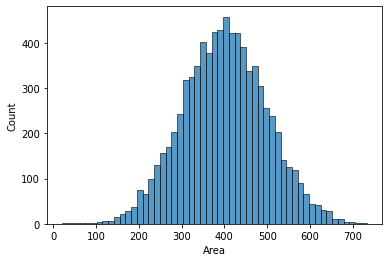

In [56]:

fig = plt.figure()
sns.histplot(df_all['Area'],  label="0") #check the distribution of 'Radius'
fig.savefig('fig_mr/2nd_MR_histogram_area.svg', format='svg', dpi=1200,bbox_inches="tight")

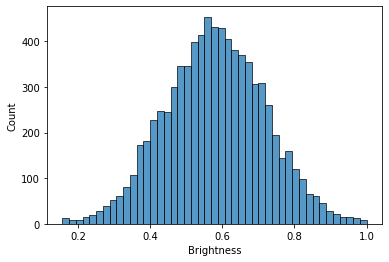

In [57]:

fig = plt.figure()
sns.histplot(df_all['Brightness'],  label="0") #check the distribution of 'Radius'
fig.savefig('fig_mr/2nd_MR_histogram_bri.svg', format='svg', dpi=1200,bbox_inches="tight")

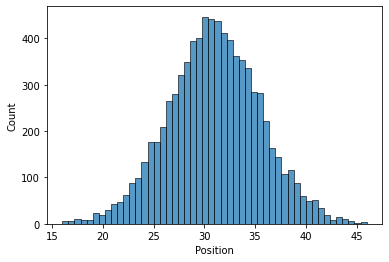

In [58]:

fig = plt.figure()
sns.histplot(df_all['Position'],  label="0") #check the distribution of 'Radius'
fig.savefig('fig_mr/2nd_MR_histogram_pos.svg', format='svg', dpi=1200,bbox_inches="tight")

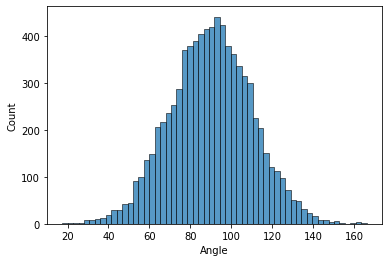

In [59]:

fig = plt.figure()
sns.histplot(df_all['Angle'],  label="0") #check the distribution of 'Radius'
fig.savefig('fig_mr/2nd_MR_histogram_rot.svg', format='svg', dpi=1200,bbox_inches="tight")

P-value of the linear regression between Brightness and Area: 3.565050208353176e-309


<Figure size 432x288 with 0 Axes>

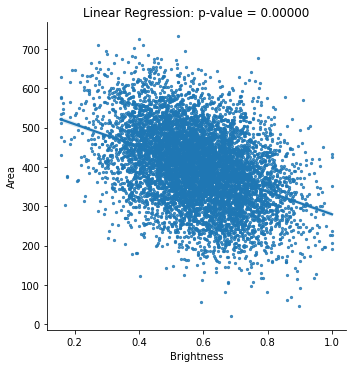

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Assuming df_all is your DataFrame with 'Brightness' and 'Area' columns

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_all['Brightness'], df_all['Area'])

# Plot the joint distribution
fig = plt.figure() # Create the figure
fig = sns.lmplot(x='Brightness', y='Area', data=df_all, scatter_kws={"s": 5})
plt.title(f"Linear Regression: p-value = {p_value:.5f}")  # Display the p-value in the title

# Save the figure
fig.savefig('fig_mr/joint_bri_area.svg', format='svg', dpi=1200, bbox_inches="tight")

# Print the p-value
print("P-value of the linear regression between Brightness and Area:", p_value)


<Figure size 432x288 with 0 Axes>

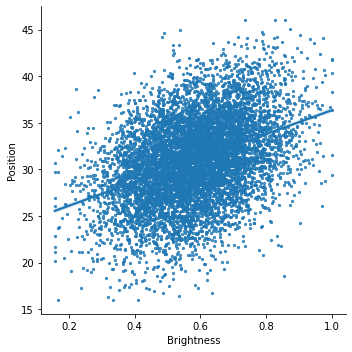

In [61]:
fig = plt.figure() #check the joint distribution
fig=sns.lmplot(x='Brightness',y='Position',data=df_all,scatter_kws={"s": 5})
fig.savefig('fig_mr/joint_bri_pos.svg', format='svg', dpi=1200,bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

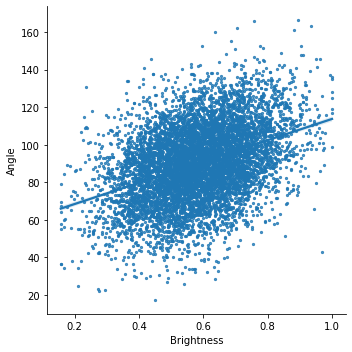

In [62]:
fig = plt.figure() #check the joint distribution
fig=sns.lmplot(x='Brightness',y='Angle',data=df_all,scatter_kws={"s": 5})
fig.savefig('fig_mr/joint_bri_rot.svg', format='svg', dpi=1200,bbox_inches="tight")

In [63]:
print(np.min(pts[:, 0]), np.max(pts[:, 0]))
print(np.min(pts[:, 1]), np.max(pts[:, 1]))
print(np.min(pts[:, 2]), np.max(pts[:, 2]))
print(np.min(pts[:, 3]), np.max(pts[:, 3]))

21.1018671211703 732.4275855653082
17.414119764041175 166.22421182844226
16.0 46.0
40.0 255.0


In [351]:
# Image size
size_img = 63

# Define aspect ratio of the ellipse (e.g., width to height ratio)
aspect_ratio = 1.5  # Width:Height ratio

# Loop through each point to generate an ellipse image
for i in range(8000):
    temp_img = np.zeros((size_img, size_img), dtype=np.uint8)
    
    # Extract values from generated data
    area = pts[i, 0]
    rotation = pts[i, 1]
    position = int(pts[i, 2])
    brightness = int(pts[i, 3])  # Convert brightness scale
    
    # Calculate width and height based on area and aspect ratio
    height = np.sqrt(area * 2 / aspect_ratio)
    width = height * aspect_ratio

    # Draw the ellipse
    center = (size_img // 2, position)
    axes = (int(width / 2), int(height / 2))
    angle = int(rotation)
    
    # Draw filled ellipse with specified brightness
    cv2.ellipse(temp_img, center, axes, angle, 0, 360, brightness, -1)

    # Save the image
    filename = f"{i}_{int(area)}_{int(rotation)}_{position}_{brightness}.png"
    cv2.imwrite(os.path.join(output_dir, filename), temp_img)

